  nuclide          score          mean     std. dev.
0   total  heating-local  1.122065e+08  42936.343273
1   total        heating  1.009014e+08  39346.999951
112206462.37066783
REACTOR_MODEL: THERMAL
P: 400000000.0
H: 112206462.37066783
Hprim: 1.7975475271780986e-11
f: 2.2252540973308494e+19
V: 21205750.411731105
factor: 1049363523631.6985

  nuclide          score          mean    std. dev.
0   total  heating-local  1.047229e+08  42359.96339
1   total        heating  9.378562e+07  38786.66823
104722918.62953117
REACTOR_MODEL: SEMIEPITHERMAL
P: 400000000.0
H: 104722918.62953117
Hprim: 1.6776611564450893e-11
f: 2.384271689568037e+19
V: 21205750.411731105
factor: 1124351481685.3867

  nuclide          score          mean     std. dev.
0   total  heating-local  7.977109e+07  36677.332895
1   total        heating  7.074788e+07  33564.916009
79771093.49582791
REACTOR_MODEL: EPITHERMAL
P: 400000000.0
H: 79771093.49582791
Hprim: 1.2779329178031631e-11
f: 3.130054750351231e+19
V: 21205750.411

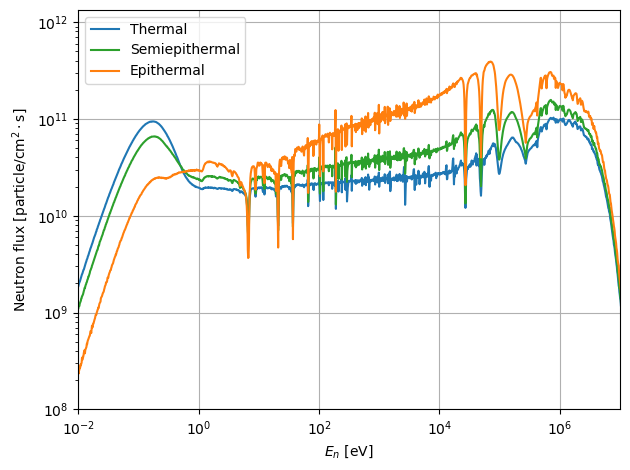

In [1]:
import openmc
import matplotlib.pyplot as plt
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, nuclear_data_tools, model_tools
import numpy as np

# Normalization to powe
P = 400 * 1e6 # W

results_idx = {
    model_tools.THERMAL_REACTOR: 1,
    model_tools.SEMIEPITHERMAL_REACTOR: 3,
    model_tools.EPITHERMAL_REACTOR: 2,
}

colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(1)

folder_filename = lambda run_id: f"../results/RUNDATA_R22_{run_id}"

for REACTOR_MODEL, i in results_idx.items():
    run_settings = run_tools.load_run_settings_json(folder_filename(i))
    color = colors[i-1]

    # Make sure reactor_model is correct
    assert run_settings["reactor_model"] == REACTOR_MODEL

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"../results/RUNDATA_R22_{i}/statepoint.{statepoint_number}.h5")

    # print(sp.tallies)

    tallydf1=sp.tallies[3].get_pandas_dataframe()
    # print(tallydf1.head())

    tallydf1flux=tallydf1[tallydf1['score']=='flux']
    # print(tallydf1flux.head())

    energy=(tallydf1flux['energy low [eV]']+tallydf1flux['energy high [eV]'])/2
    
    # Tally 4
    tallydf4=sp.tallies[4].get_pandas_dataframe()
    print(tallydf4.head())
    # Get normalization:
    heating_local = tallydf4[tallydf4['score']=='heating-local']["mean"][0]
    print(heating_local)
    H = heating_local # eV/source
    Hprim = 1.602e-19 * H; # J/ev 
    f = P / Hprim; # source/s
    V = 150**2 * np.pi *300; # cm^3 
    factor = f/V # (source/s) / (cm^3)

    print(f"REACTOR_MODEL: {REACTOR_MODEL}")
    print(f"P: {P}")
    print(f"H: {H}")
    print(f"Hprim: {Hprim}")
    print(f"f: {f}")
    print(f"V: {V}")
    print(f"factor: {factor}")
    print("")




    plt.figure(1)
    # factor = 21205750.411731105
    plt.loglog(energy,tallydf1flux['mean']*factor, label=REACTOR_MODEL.capitalize(), color=color)

    


    # deltaE=(tallydf1flux['energy high [eV]']-tallydf1flux['energy low [eV]'])
    # plt.figure(2)
    # plt.loglog(energy,tallydf1flux['mean']/deltaE,lw=2, label=labels[i])

    

plt.figure(1)
plt.xlabel('$E_n$ [eV]')
plt.ylabel('Neutron flux [particle/cm$^2\cdot$s]')
plt.legend()
plt.xlim(1e-2, 1e7)
plt.ylim(bottom=1e8)
plt.grid()
plt.tight_layout()
plt.savefig("group_plux_per_source_particle.pdf")


# plt.figure(2)
# plt.ylabel('Spectrum per source particle (1/eV)')
# plt.xlabel('Energy (eV)')
# plt.legend()
# plt.savefig("spectrum_per_source_particle.pdf")
    